In [15]:
import qiskit
print(qiskit.__version__)


1.1.1


In [16]:
try:
    from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
    from qiskit.circuit import Parameter
    print("Imports successful!")
except ImportError as e:
    print(f"ImportError: {e}")


Imports successful!


In [17]:

import numpy as np

np.random.seed(999999)
p0 = np.random.random()
target_distr = {0: p0, 1: 1 - p0}

In [18]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter

params = [Parameter("theta"), Parameter("phi"), Parameter("lam")]


def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name="c")
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc


qc = get_var_form(params)

In [19]:
from qiskit_aer.primitives import Sampler

sampler = Sampler()


def objective_function(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Simulate the circuit instance with paramters
    result = sampler.run(circuits=qc, parameter_values=params).result()
    # Get the quasi distribution for each measured state
    output_distr = result.quasi_dists[0]
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(
        abs(target_distr.get(i, 0) - output_distr.get(i, 0))
        for i in range(2**qc.num_qubits)
    )
    return cost

In [20]:
from qiskit_algorithms.optimizers import SPSA, SLSQP, COBYLA
import numpy as np

optimizer = COBYLA(maxiter=500, tol=0.0001)
# Create the initial parameters (noting that our
# single qubit variational form has 3 parameters)
initial_point = np.random.rand(3)

result = optimizer.minimize(fun=objective_function, x0=initial_point)

# Obtain the output distribution using the final parameters
output_distr = (
    sampler.run(circuits=qc, parameter_values=result.x)
    .result()
    .quasi_dists[0]
)

print("Parameters Found:", result.x)
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Cost:", objective_function(result.x))


Parameters Found: [-0.24839065  0.88725095  1.9598656 ]
Target Distribution: {0: 0.308979188922057, 1: 0.691020811077943}
Obtained Distribution: {1: 0.67578125, 0: 0.32421875}
Cost: 0.039833377844114004


linear entanglement:


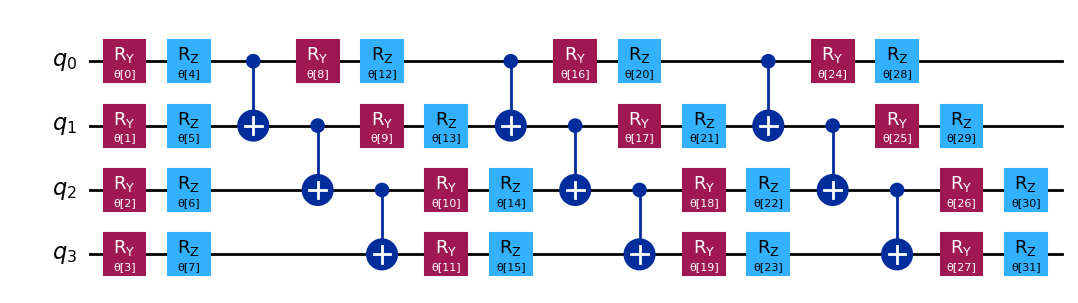

full entanglement:


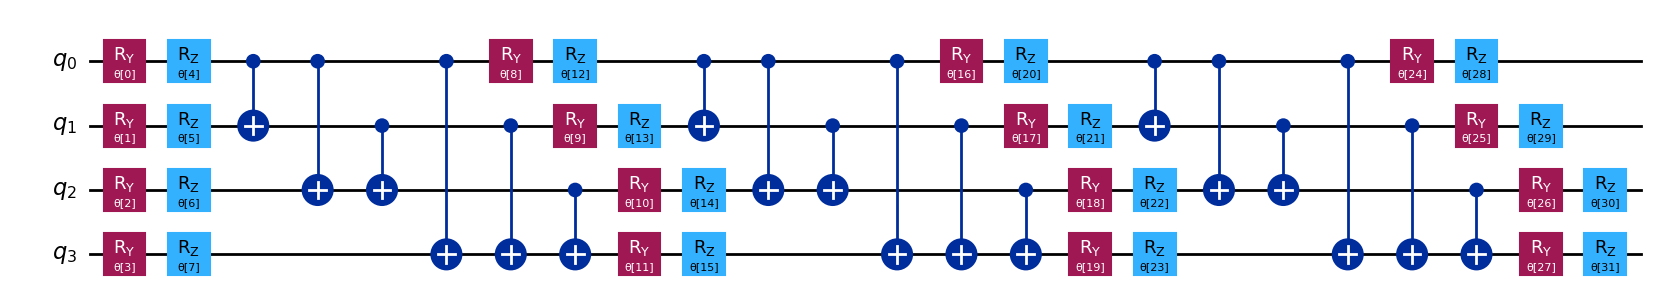

In [21]:
from qiskit.circuit.library import EfficientSU2

entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    print(f"{entanglement} entanglement:")
    # We initialize all parameters to 0 for this demonstration
    display(form.decompose().draw("mpl", fold=-1))

In [22]:
from qiskit_algorithms import MinimumEigensolverResult
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.circuit.library import EfficientSU2
import numpy as np
from qiskit_algorithms.optimizers import SLSQP , SPSA , ADAM
from qiskit_aer.primitives import Estimator
#qiskit_nature.settings.use_pauli_sum_op = False 
from qiskit_aer import Aer
from pyinstrument import Profiler
import threading
from qiskit_aer.primitives import Estimator as AerEstimator
import math
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
import cupy as cp



In [23]:



def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "F" ],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [24]:
# from qiskit_aer import *
# from qiskit_aer import Aer

# try:
#     simulator_gpu = Aer.get_backend('aer_simulator_statevector')
#     simulator_gpu.set_options(device='GPU')
#     simulator_gpu.set_options(cuStateVec_enable=False)
#     print("GPU options set successfully." , simulator_gpu)
# except Exception as e:
#     print(f"Failed to set GPU options: {e}")

# print(Aer.backends())

In [25]:


import time


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


start_time = time.time()
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=20)


noiseless_estimator = Estimator(approximation=True)



for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
 
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")
end_time = time.time()
execution_time1 = end_time - start_time
print(f"Execution time: {execution_time1} seconds")

Interatomic Distance: 0.5 VQE Result: -97.71382 Exact Energy: -97.71382
Interatomic Distance: 0.7 VQE Result: -98.43762 Exact Energy: -98.43762
Interatomic Distance: 0.9 VQE Result: -98.59295 Exact Energy: -98.59295
Interatomic Distance: 1.1 VQE Result: -98.59510 Exact Energy: -98.59510
Interatomic Distance: 1.3 VQE Result: -98.55816 Exact Energy: -98.55816
Interatomic Distance: 1.5 VQE Result: -98.51935 Exact Energy: -98.51935
Interatomic Distance: 1.7 VQE Result: -98.48986 Exact Energy: -98.48986
Interatomic Distance: 1.9 VQE Result: -98.47160 Exact Energy: -98.47160
Interatomic Distance: 2.1 VQE Result: -98.46187 Exact Energy: -98.46187
Interatomic Distance: 2.3 VQE Result: -98.45711 Exact Energy: -98.45711
Interatomic Distance: 2.5 VQE Result: -98.45178 Exact Energy: -98.45488
Interatomic Distance: 2.7 VQE Result: -98.45302 Exact Energy: -98.45387
Interatomic Distance: 2.9 VQE Result: -98.45297 Exact Energy: -98.45342
Interatomic Distance: 3.1 VQE Result: -98.45302 Exact Energy: -9

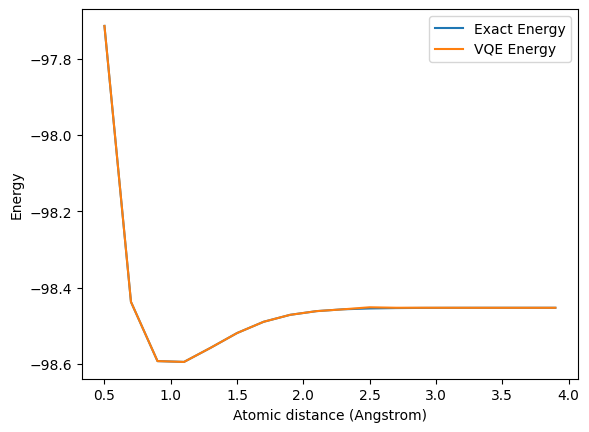

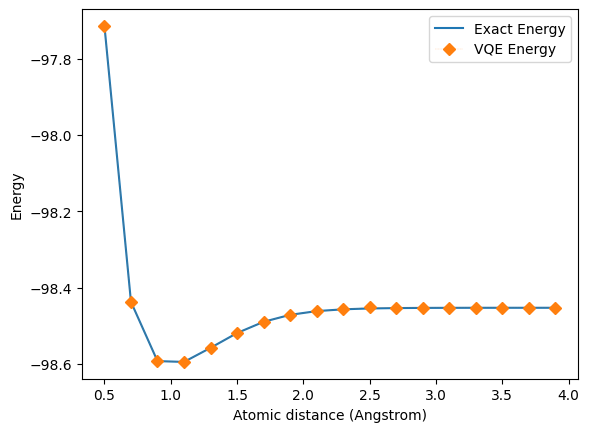

In [26]:
import matplotlib.pyplot as plt

plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()


plt.plot(distances, exact_energies, label="Exact Energy", ls='-', linewidth=1.5)
plt.plot(distances, vqe_energies, label="VQE Energy", ls=':', marker='D', linewidth=0.2)
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()


In [27]:
from qiskit_aer.primitives import Estimator
from qiskit_aer import *
import matplotlib.pyplot as plt
import numpy as np
import psutil
import time
import ray
import os

start_time = time.time()
ray.shutdown()
ray.init()

distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
times = []
pids = []
cpu_name = []
optimizer = SLSQP(maxiter=20)
noiseless_estimator = Estimator(approximation=True)

# backend= {
#     "method": "statevector",
#     "precision": "double",
#     "max_parallel_threads": 4,
#     "device": "GPU"
# }
# noiseless_estimator = AerEstimator(backend_options = backend , approximation=True)


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


@ray.remote
def compute_energy(dist):
        pid = os.getpid()
        p = psutil.Process(pid)
        affinity = p.cpu_num()
        qubit_op, num_particles, num_spatial_orbitals, problem, mapper = get_qubit_op(dist)
        start = time.time()
        result = exact_solver(qubit_op, problem)
        exact_energy = result.total_energies[0].real   
        init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)

        var_form = UCCSD(
            num_spatial_orbitals, num_particles, mapper, initial_state=init_state
        )
        vqe = VQE(
            noiseless_estimator,
            var_form,
            optimizer,
            initial_point=[0] * var_form.num_parameters,
            
        )

        vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
        vqe_result = problem.interpret(vqe_calc).total_energies[0].real
        end = time.time()
        computation_time = end - start
        return dist , exact_energy, vqe_result , computation_time , pid , affinity

results = [compute_energy.remote(dist) for dist in distances]


for result in ray.get(results):
   
    dist, exact_energy, vqe_result , computation_time , pid , affinity   = result
    exact_energies.append(exact_energy)
    vqe_energies.append(vqe_result)
    times.append(computation_time)
    pids.append(pid)
    cpu_name.append(affinity)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energy:.5f}",
          f"ComputationTime: {computation_time:.5f} sec "
          f"PID NO = : {pid} "
          f"CPU Number: {affinity} "

          )
          
print("All energies have been calculated")
end_time = time.time()
execution_time2 = end_time - start_time
print(f"Execution time: {execution_time2} seconds")

ray.shutdown()


2024-09-04 12:18:10,514	INFO worker.py:1788 -- Started a local Ray instance.


Interatomic Distance: 0.5 VQE Result: -97.71382 Exact Energy: -97.71382 ComputationTime: 6.92068 sec PID NO = : 2471879 CPU Number: 42 
Interatomic Distance: 0.7 VQE Result: -98.43762 Exact Energy: -98.43762 ComputationTime: 7.07715 sec PID NO = : 2471888 CPU Number: 44 
Interatomic Distance: 0.9 VQE Result: -98.59295 Exact Energy: -98.59295 ComputationTime: 7.93392 sec PID NO = : 2471868 CPU Number: 60 
Interatomic Distance: 1.1 VQE Result: -98.59510 Exact Energy: -98.59510 ComputationTime: 7.96612 sec PID NO = : 2471875 CPU Number: 18 
Interatomic Distance: 1.3 VQE Result: -98.55816 Exact Energy: -98.55816 ComputationTime: 8.28136 sec PID NO = : 2471873 CPU Number: 27 
Interatomic Distance: 1.5 VQE Result: -98.51935 Exact Energy: -98.51935 ComputationTime: 7.89073 sec PID NO = : 2471859 CPU Number: 15 
Interatomic Distance: 1.7 VQE Result: -98.48986 Exact Energy: -98.48986 ComputationTime: 11.15988 sec PID NO = : 2471857 CPU Number: 6 
Interatomic Distance: 1.9 VQE Result: -98.47160 

In [28]:
speedup = execution_time1/execution_time2
print(f"total speed up {speedup}x" )

total speed up 8.855111403888676x


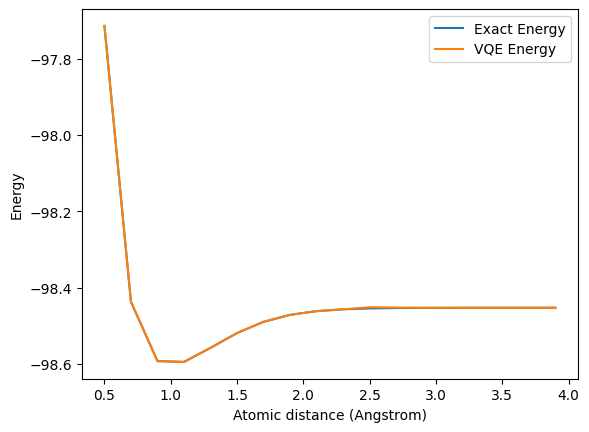

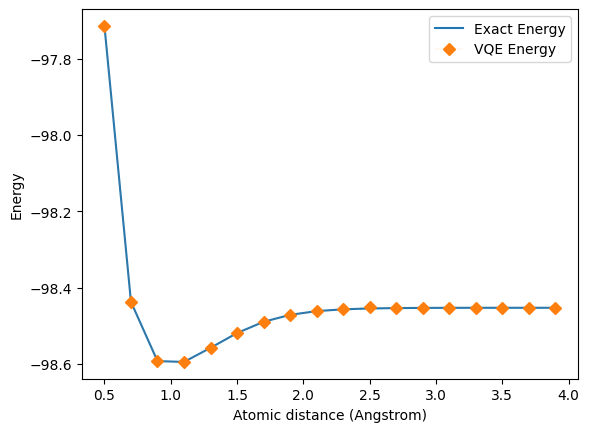

<Figure size 640x480 with 0 Axes>

In [29]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()
plt.savefig("img1")

plt.plot(distances, exact_energies, label="Exact Energy", ls='-', linewidth=1.5)
plt.plot(distances, vqe_energies, label="VQE Energy", ls=':', marker='D', linewidth=0.2)
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()
plt.savefig("img2")

